In [1]:
import math
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import geojson
from mpas_tools.mesh.creation.signed_distance import mask_from_geojson

In [2]:
lev = xr.open_dataset('/pscratch/sd/a/abhi305/depth_files/hr_depth.nc').refBottomDepth
ds_v = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_velocityMeridional/mer_v_highres_111_120_re_time_av.nc')
ds_w = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_vertVelocityTop/vertVelocityTop_111_120_re_time_avg.nc')
ds_pd = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_potentialDensity/potentialDensity_111_120_re_time_av.nc')

In [3]:
v = ds_v.timeMonthly_avg_velocityMeridional[0,...].values
w = ds_w.timeMonthly_avg_vertVelocityTop[0,...].values
pd = ds_pd.timeMonthly_avg_potentialDensity[0,...].values
lat = ds_v.lat.values
lon = ds_v.lon.values

In [4]:
with open('/pscratch/sd/a/abhi305/mask_files/atlantic_mask.geojson') as f:
    fc = geojson.load(f) 
na_mask = mask_from_geojson(fc,lon,lat)   

Mask from geojson
-----------------


In [5]:
v[:,~na_mask] = np.nan
w[:,~na_mask] = np.nan
pd[:,~na_mask] = np.nan

In [6]:
dist_lon = 0.1*111*np.cos(np.deg2rad(lat))*1000 
dist_lat = 11076

In [7]:
v[v == 0] = np.nan
w[w == 0] = np.nan

# SOUTHERN TRANSECT

In [8]:
southern_boundary_lat_index = np.where(~np.isnan(v[0,:,1500]))[0].min()

In [9]:
#southern_boundary_lat_index = np.argmax(~np.isnan(v[0,:,800]))
v_south = v[:,southern_boundary_lat_index,:]

In [10]:
'''
fig,ax=plt.subplots(figsize=(8,6))
c = ax.pcolormesh(lon,lev,v_south,cmap='RdBu',vmin=-0.1,vmax=0.1)
ax.set_xlim(-60,20)
ax.set_ylim(4000,0)
cax = fig.add_axes([0.92,0.15,0.02,0.7])
fig.colorbar(c,cax=cax)
'''

"\nfig,ax=plt.subplots(figsize=(8,6))\nc = ax.pcolormesh(lon,lev,v_south,cmap='RdBu',vmin=-0.1,vmax=0.1)\nax.set_xlim(-60,20)\nax.set_ylim(4000,0)\ncax = fig.add_axes([0.92,0.15,0.02,0.7])\nfig.colorbar(c,cax=cax)\n"

In [11]:
layer_thickness = np.diff(lev, prepend=0)

In [12]:
v_south_dz = v_south * layer_thickness[:,None]

In [13]:
v_south_dz.shape

(80, 3600)

## here goes isopycnal transformation

### We take zonal sum of Southern Transect at last

In [14]:
southern_transport_z = np.nansum(v_south_dz,axis=1)*9000

In [15]:
southern_psi = np.flip(np.nancumsum(np.flip(southern_transport_z)))

In [17]:
w_da = w * dist_lon[None,:,None] * dist_lat

In [18]:
#del_w_interior_da_zonal_sum_z = np.nansum(del_w_interior_da, axis = 2)

In [44]:
w_da_zonal_sum = np.nansum(w_da, axis=2)

In [45]:
w_da_zonal_sum.shape

(81, 1800)

In [46]:
interior_transport_z = np.nancumsum(w_da_zonal_sum, axis=1)

In [47]:
total_transport_z = southern_transport_z[:,None] + interior_transport_z

In [51]:
psi = np.flip(np.cumsum(np.flip(total_transport_z, axis=0), axis=0), axis=0)

In [72]:
lev1 = np.insert(lev,0,0)

/tmp/ipykernel_1843790/1677530660.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


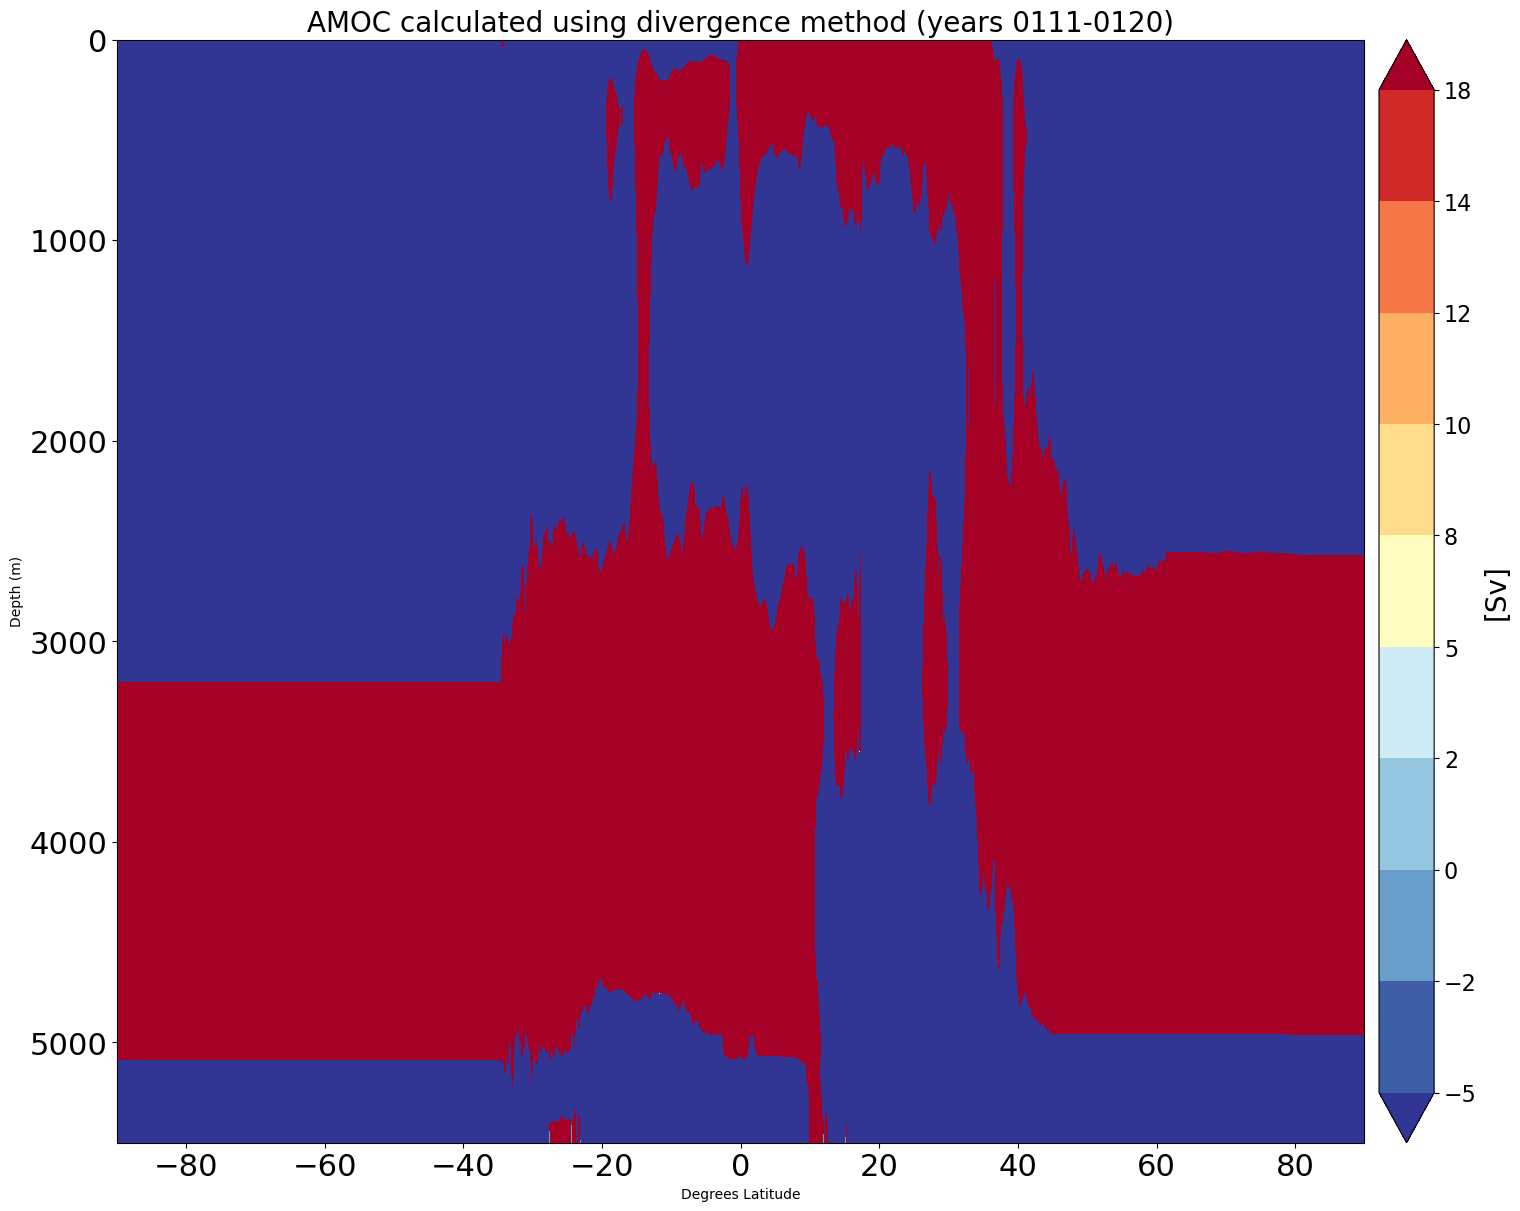

In [57]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat, lev, psi,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
#plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_years_0111_0120', dpi=300)

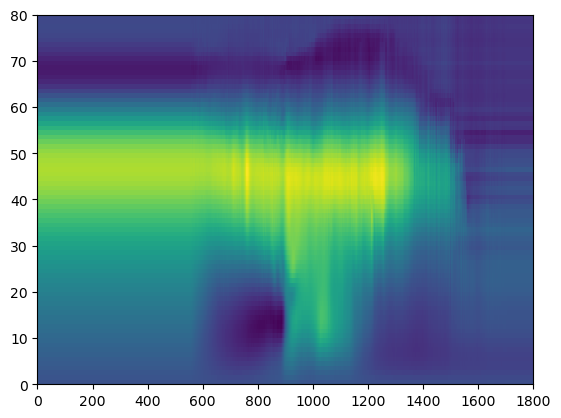

In [67]:
plt.pcolormesh(np.nancumsum(southern_transport_z[:,None]+interior_transport_z,axis=0))

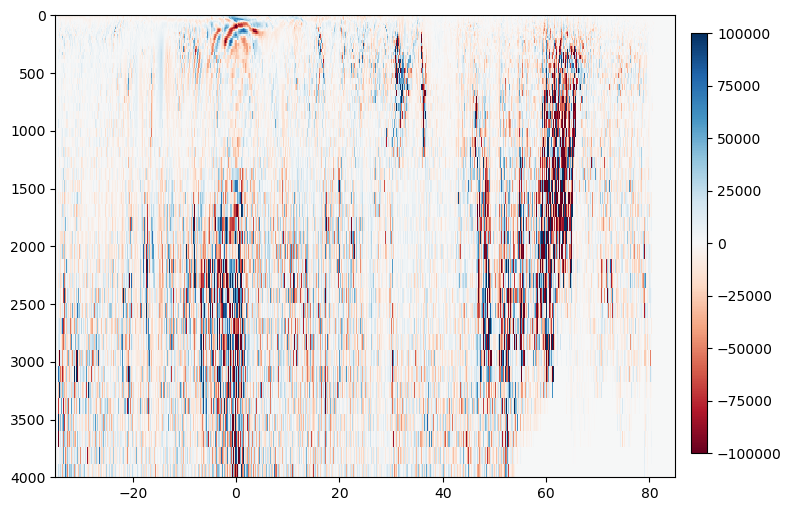

In [59]:
fig,ax=plt.subplots(figsize=(8,6))
c = ax.pcolormesh(lat,lev,del_w_interior_da_zonal_sum_z,cmap='RdBu',vmin=-1e5,vmax=1e5)
ax.set_xlim(-35,85)
ax.set_ylim(4000,0)
cax = fig.add_axes([0.92,0.15,0.02,0.7])
fig.colorbar(c,cax=cax)

# INTERIOR

# W (zonal sum earlier)


In [16]:
w_zonalsum = np.nansum(w, axis=2)

In [17]:
w_zonalsum_da = w_zonalsum * dist_lon[None,:] * dist_lat 

In [18]:
w_zonalsum_da_diff = np.diff(w_zonalsum_da, axis=0)

In [19]:
w_zonalsum_da_diff_zcum = np.flip(np.nancumsum(np.flip(w_zonalsum_da_diff, axis=0), axis=0), axis=0)

In [20]:
w_zonalsum_da_diff_zcum_latcum = np.nancumsum(w_zonalsum_da_diff_zcum, axis=1)

# W (zonal sum later)

In [23]:
w_da = w * dist_lon[None,:,None] * dist_lat

In [24]:
w_da_diff = np.diff(w_da, axis=0)

## here goes isopycnal codes

### Zonal sum --> cumsum in depth --> cumsum in lat

In [25]:
w_da_diff.shape

(80, 1800, 3600)

In [26]:
w_da_diff_zonalsum = np.nansum(w_da_diff, axis=2)

In [27]:
w_da_diff_zonalsum.shape

(80, 1800)

In [28]:
w_da_diff_zonalsum_zcum = np.flip(np.nancumsum(np.flip(w_da_diff_zonalsum, axis=0), axis=0), axis=0)

In [29]:
w_da_diff_zonalsum_zcum.shape

(80, 1800)

In [30]:
w_da_diff_zonalsum_zcum_latcum = np.nancumsum(w_da_diff_zonalsum_zcum, axis=1)

In [31]:
w_da_diff_zonalsum_zcum_latcum.shape

(80, 1800)

### Cumsum in depth --> cumsum in lat --> Zonal sum 

In [19]:
w_da_diff_zcum = np.flip(np.nancumsum(np.flip(w_da_diff, axis=0), axis=0), axis=0)

In [20]:
w_da_diff_zcum.shape

(80, 1800, 3600)

In [21]:
w_da_diff_zcum_latcum = np.nancumsum(w_da_diff_zcum, axis=1)

In [22]:
w_da_diff_zcum_latcum.shape

(80, 1800, 3600)

In [23]:
w_da_diff_zcum_latcum_zonalsum = np.nansum(w_da_diff_zcum_latcum, axis=2)

In [24]:
w_da_diff_zcum_latcum_zonalsum.shape

(80, 1800)

# Total psi

In [25]:
w_zonal_sum_da = w_zonal_sum * dist_lon[None,:] * dist_lat 

NameError: name 'w_zonal_sum' is not defined

In [122]:
w_zonal_sum_da[5,1200:1600:10]

array([  61729.9084481 ,   84636.58245945,   49476.49844338,
        -14906.44012402,  -51058.4034308 ,   58772.26241239,
          5723.68185886,  -52368.22747254,  -81556.62124251,
         -3744.39415276,  -24805.4305528 ,  -35626.70531913,
         46637.02942532,   44475.0568001 ,  -95267.49261573,
         58438.43830364,  -25829.15189041, -369213.16523145,
        -86467.21898642, -120899.80535428,   64116.57898227,
         30533.16114436,  271886.97657835,  113649.41476049,
           916.22253152,  -97087.19381163,   41540.73028903,
         -9079.86499602,  -46818.51160932,  110266.57216813,
       -351849.55298197,  -49659.49075507, -183439.26206122,
        -13824.60763523,   21375.23362936,  -85844.32239673,
         19019.98526084,   26759.19754098,  -11746.79879745,
         21917.38227515])

In [148]:
w_zonal_sum_da_diff = np.diff(w_zonal_sum_da, axis=0)

In [149]:
w_zonal_sum_da_diff[:,1370].shape

(80,)

In [150]:
w_zonal_sum_da_diff[:,1370]

array([ 3.36482179e+02,  4.11221323e+02,  5.51922832e+02,  7.65959201e+02,
        8.62971858e+02, -5.92139981e+01,  5.72128927e+02,  1.52676936e+02,
        9.02252818e+01,  1.49540700e+03, -1.78110089e+02, -2.39738677e+03,
       -4.22697448e+03, -2.78621755e+03, -1.67343908e+01, -1.64660164e+03,
       -4.31915016e+03, -3.46043016e+03, -2.08563560e+03, -5.86768593e+03,
        6.13036516e+03,  8.50298190e+03,  1.86584556e+04,  1.41761744e+04,
        1.55960231e+04,  1.23794704e+04,  4.04541220e+03,  1.57927400e+03,
        2.86267304e+03,  4.05896744e+02,  3.05879113e+04,  9.74314069e+03,
        4.65592490e+03,  4.03594108e+04,  2.35051682e+04,  1.07062653e+04,
        1.41538034e+04,  1.26128937e+04,  5.90545533e+03,  1.65235726e+04,
        2.63486396e+04,  2.25364947e+04,  2.05502805e+04,  7.13735956e+04,
        8.28789232e+03,  2.83638732e+04, -4.13481027e+04,  1.48817884e+04,
        7.12065150e+03, -6.57388185e+04, -2.42508823e+04, -1.21720361e+04,
       -8.03084974e+03, -

In [32]:
final_psi = -0.000001* (southern_psi[:,None] + w_da_diff_zonalsum_zcum_latcum)

/tmp/ipykernel_207162/1383818467.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


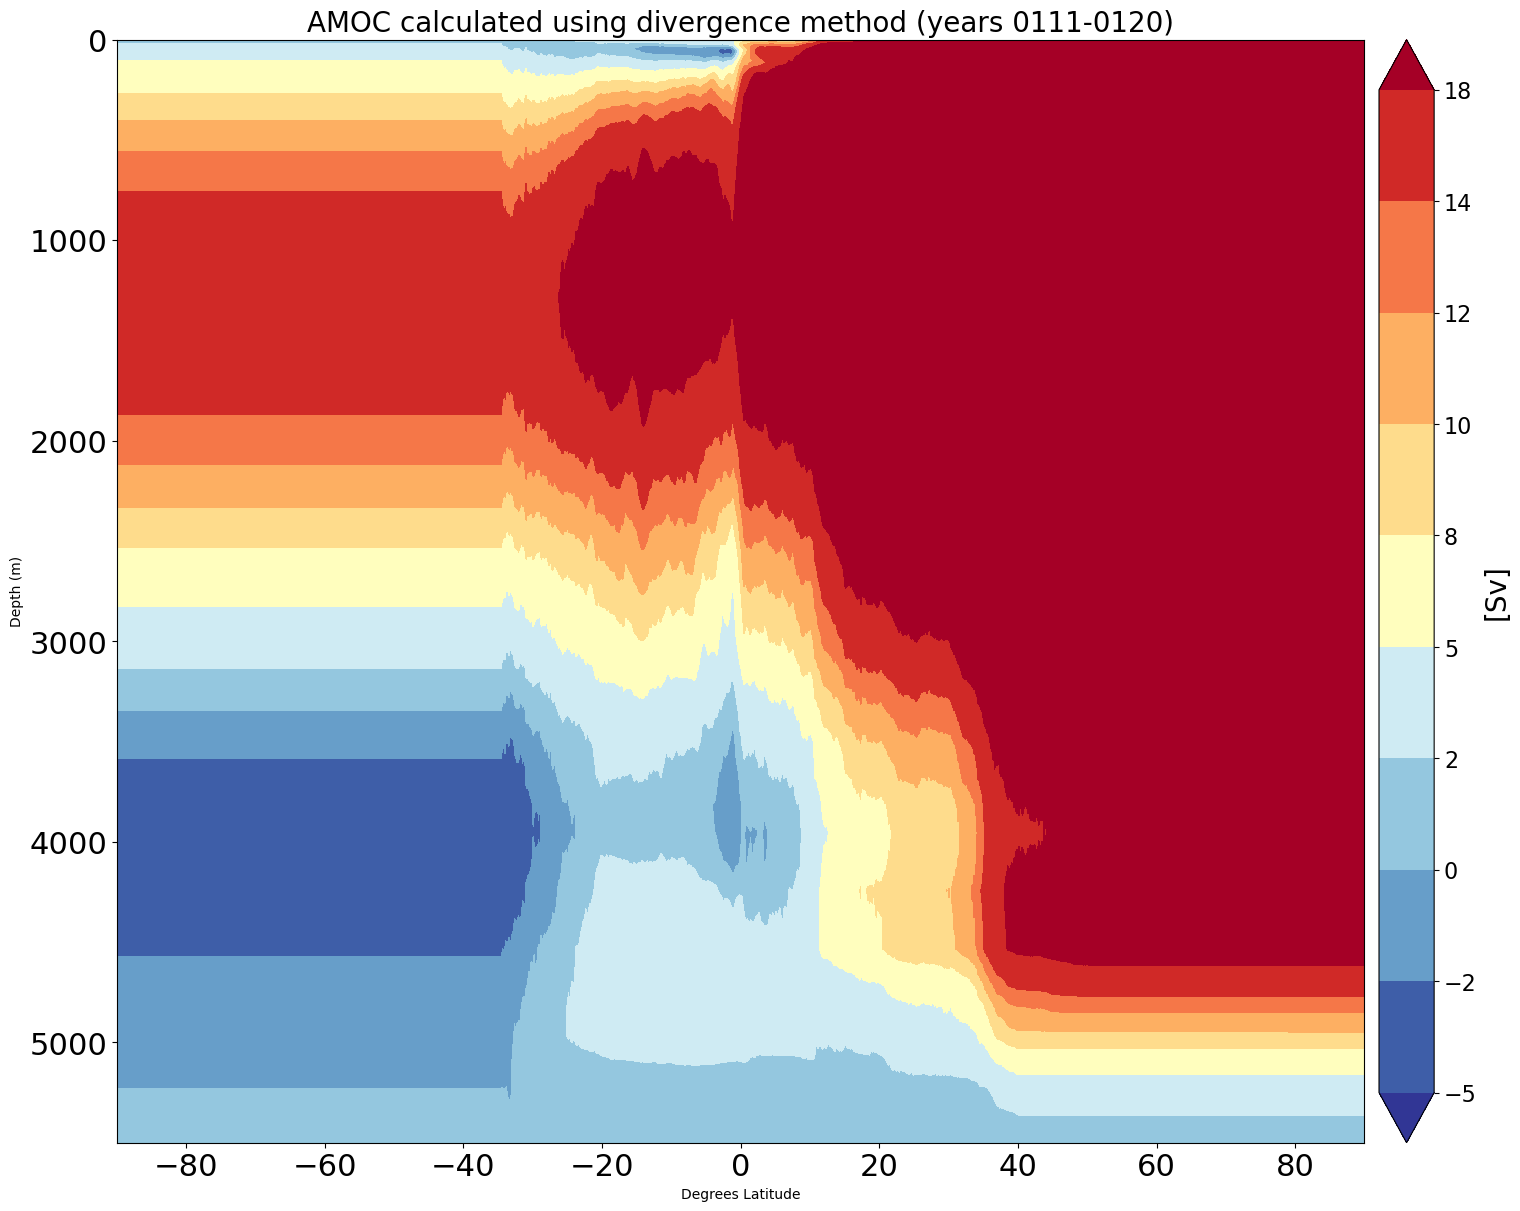

In [33]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat, lev, final_psi,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
#plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_years_0111_0120', dpi=300)